# Week 2

* **Trading Periods**: fix trading periods
* **Pre-Training**: `tangency-portfolio` sharpe ratio with transaction costs
* **Project**: folder structure refinements

In [1]:
import qtrader

import datetime

import numpy as np

from keras.models import Model
from keras.layers import Input
from keras.layers import Flatten
from keras.layers import Dense

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-muted')
plt.style.use('seaborn-ticks')
plt.style.use('seaborn-poster')

import warnings
warnings.filterwarnings('ignore')

/Users/alpha/Developer/qtrader/.env/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


### Data Source

In [2]:
# three-years window
start_date = datetime.date.today() - datetime.timedelta(days=10*365)

# trading period
freq = 'W'

# stock tickers
TICKERS = ['AAPL', 'JPM', 'GOOG', 'MSFT', 'VOD', 'GS', 'TSLA']

# prices
prices = qtrader.envs.data_loader.Finance.Prices(tickers=TICKERS,
                                                 source='quandl',
                                                 start_date=start_date,
                                                 freq=freq)

# returns
returns = qtrader.envs.data_loader.Finance.Returns(tickers=TICKERS,
                                                   source='quandl',
                                                   start_date=start_date,
                                                   freq=freq).dropna()

# log-returns
rhos = np.log(1 + returns)

## Tangency Portfolio with Transaction Costs

Determine portfolio vector $\mathbf{w}$, such that:

\begin{aligned}
& \underset{\mathbf{w}}{\text{maximize}}
& & \frac{\mathbf{w}^{T} \mathbf{r}}{\sqrt{\mathbf{w}^{T} \boldsymbol{\Sigma} \mathbf{w}}} -
    \mathbf{1}^{T} \gamma \|(\mathbf{w_{0}} - \mathbf{w})\| & \text{ (utility function) } \\
& \text{subject to}
& & \mathbf{w}^{T} \mathbf{1} = 1 & \text{ (budget constraint) } \\
&
& & 
\end{aligned}

where:

* $M$: number of assets in portfolio
* $\gamma \geq 0$: transaction costs coefficient
* $\boldsymbol{\Sigma} \in \mathbb{R}^{M \times M}$: portfolio returns covariance
* $\mathbf{r} \in \mathbb{R}^{M}$: portfolio returns mean
* $\mathbf{w_{0}} \mathbb{R}^{M}$: initial portfolio weights

### Dataset Generation

Generate $(\mathbf{X}_{i}, \mathbf{w}_{i})$ pairs such that:

\begin{aligned}
    \mathbf{w}_{i} = \mathtt{tangency\_portfolio}(\mathbf{X}_{i}, \mathbf{w_{0}})
\end{aligned}

where:

* $M$: number of assets in portfolio
* $T$: window size
* $\mathbf{X}_{i} \in \mathbb{R}^{T \times M}$: returns data
* $\mathbf{w}_{i} \mathbb{R}^{M}$: tangency portfolio vector
* $\mathbf{w_{0}} \mathbb{R}^{M}$: initial portfolio weights

In [3]:
# objective function
J = qtrader.agents.pretrainer.objectives.sharpe_ratio

# hyperparmeters
gamma = 0
window = 15

# dataset generator
X, w = qtrader.agents.pretrainer.generator(
    100, returns, qtrader.agents.pretrainer.optimizer(J, gamma), window)

### Agent

In [4]:
# input layer
FC_X = Input(shape=(window, X.shape[-1]), name="X")
# flatten
FC_Flatten = Flatten(name="Flatten")(FC_X)
# affine
FC_Dense1 = Dense(16, activation='relu', name="Dense1")(FC_Flatten)
# affine
FC_w = Dense(w.shape[-1], activation='softmax', name="w")(FC_Dense1)

# agent model
FC = Model(inputs=FC_X, outputs=FC_w)
# Compile Graph
FC.compile(optimizer='rmsprop',
              loss='mse')
# Computational Graph Summary
FC.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               (None, 15, 7)             0         
_________________________________________________________________
Flatten (Flatten)            (None, 105)               0         
_________________________________________________________________
Dense1 (Dense)               (None, 16)                1696      
_________________________________________________________________
w (Dense)                    (None, 7)                 119       
Total params: 1,815
Trainable params: 1,815
Non-trainable params: 0
_________________________________________________________________


In [5]:
# model training
history = FC.fit(X, w, epochs=1000, validation_split=0.25, verbose=0)

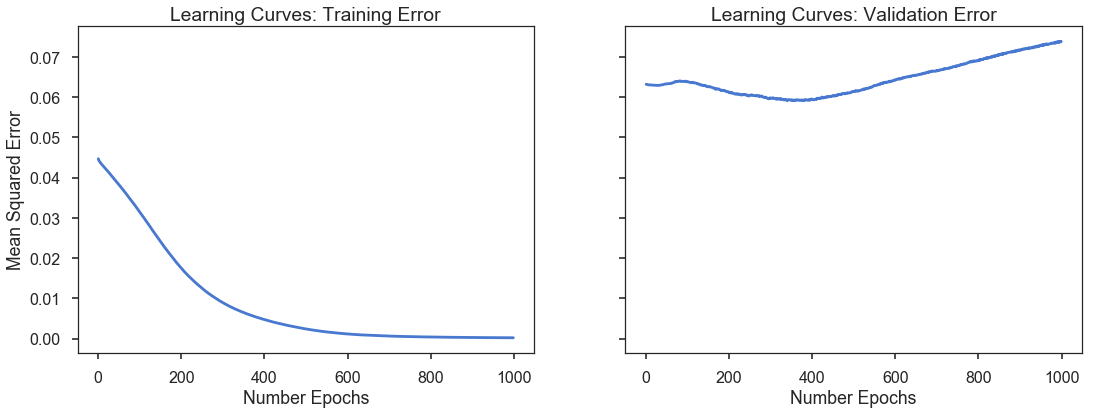

In [6]:
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(18.0, 6.0))

axes[0].plot(history.history['loss'])
axes[0].set_title('Learning Curves: Training Error')
axes[0].set_xlabel('Number Epochs')
axes[0].set_ylabel('Mean Squared Error')

axes[1].plot(history.history['val_loss'])
axes[1].set_title('Learning Curves: Validation Error')
axes[1].set_xlabel('Number Epochs');

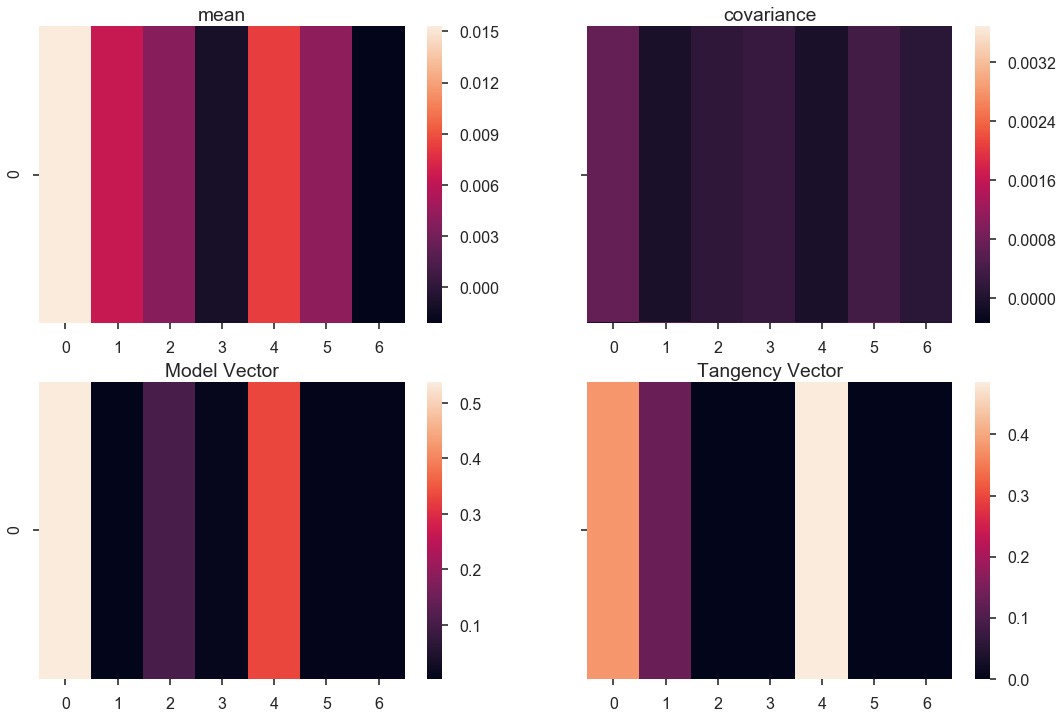

In [7]:
xi = X[1]

fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(18.0, 12.0))

sns.heatmap( xi.mean(axis=0).reshape(1, -1), ax=axes[0, 0] )
axes[0, 0].set_title("mean")

sns.heatmap( np.cov(xi.T), ax=axes[0, 1] )
axes[0, 1].set_title("covariance")


wi = FC.predict(xi.reshape(*((1,) + xi.shape)))
sns.heatmap( wi, ax=axes[1, 0] )
axes[1, 0].set_title("Model Vector")

# initial random weights
w0 = np.random.uniform(0, 1.0, X.shape[-1])
w0 = w0 / np.sum(w0)

wj = qtrader.agents.pretrainer.optimizer(J, gamma)(np.mean(xi, axis=0), np.cov(xi.T), w0)
sns.heatmap( wj.reshape(1,-1), ax=axes[1, 1] )
axes[1, 1].set_title("Tangency Vector");